In [2]:
import datetime
import numpy as np
import pandas as pd
import os
import pathlib
import scipy
import matplotlib.pyplot as plt

import pickle

from text_preprocessing import *
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython.display import display

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/pasha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/pasha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pasha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pasha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
!which python

/home/pasha/Study/API_Design/Air_alarms/alarms_env/bin/python


# Data Preprocessing
**Table of content**

* [Upload data](#data)
* [Preparing ISW reports](#nlp)
    * [Preprocess text](#preprocessing)
    * [Convert datetime columns](#ISW_to_datetime)
* [Prepare alarms data](#alarms)
    * [Convert datetime columns](#alarms_to_datetime)
* [Prepare weather](#weather)
    *  [Drop unnecessary data](#weather_drop)
* [Merging](#merging)
    * [Merge weather and regions](#weather_region)
    * [Merge events](#+events)
        * [Round times to hours](#rounding)
    * [Merge ISW data](#+ISW)
* [Create TF-IDF vector](#tfidf)
* [Convert all data to float datatype](#tofloat)
* [Extract y vector](#y)
* [Join data and TF-IDF vector](#data+tfidf)
* [Test/Train split](#spliting)

## Upload data <a class="anchor" id="data"></a>

In [4]:
data_folder = os.path.join(pathlib.Path().resolve(), 'data/data_before_lab_3')
alarms_path = os.path.join(data_folder, 'alarms.csv')
all_weather_by_hour_path = os.path.join(data_folder, 'all_weather_by_hour.csv')
regions_path = os.path.join(data_folder, 'regions.csv')
reports_path = os.path.join(data_folder, 'reports_processed.csv')

In [5]:
alarms = pd.read_csv(alarms_path, sep=';')
all_weather_by_hour = pd.read_csv(all_weather_by_hour_path)
regions = pd.read_csv(regions_path)
reports = pd.read_csv(reports_path, sep=';')

alarms.columns

Index(['id', 'region_id', 'region_title', 'region_city', 'all_region', 'start',
       'end', 'clean_end', 'intersection_alarm_id'],
      dtype='object')

## Preparing ISW reports  <a class="anchor" id="nlp"></a>

## Preprocess text <a class="anchor" id="preprocessing"></a>

In [6]:
reports.head()

,date,url,page_title,content_title,content_html,content_text
0,2022-02-25,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces entered major Ukrainian citie...
1,2022-02-26,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces’ main axes of advance in the ...
2,2022-02-27,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nThe Russian military has likely recognized t...
3,2022-02-28,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, Februar...","Russian Offensive Campaign Assessment, Februar...","<div class=""field field-name-body field-type-t...",\nThe Russian military is reorganizing its mil...
4,2022-03-01,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, March 1...","Russian Offensive Campaign Assessment, March 1","<div class=""field field-name-body field-type-t...",\nRussian forces are completing the reinforcem...


In [7]:
def preprocess(data, word_root_algo="lemm"):
    data = remove_one_letter_word(data)
    data = remove_url_from_string(data)
    data = convert_lower_case(data)
    data = remove_punctuation(data)
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    
    if word_root_algo == "lemm":
        data = lemmatizing(data)
    else:
        data = stemming(data)
        
    data = remove_punctuation(data)
    data = remove_stop_words(data)
    
    return data

In [8]:
reports['content_text_lemm'] = reports['content_text'].apply(lambda x: preprocess(x, "lemm"))

In [9]:
reports.head()

,date,url,page_title,content_title,content_html,content_text,content_text_lemm
0,2022-02-25,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces entered major Ukrainian citie...,russian forc enter major ukrainian citi inclu...
1,2022-02-26,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces’ main axes of advance in the ...,russian forc main axe advanc last twenti four...
2,2022-02-27,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nThe Russian military has likely recognized t...,russian militari like recogn initi expect lim...
3,2022-02-28,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, Februar...","Russian Offensive Campaign Assessment, Februar...","<div class=""field field-name-body field-type-t...",\nThe Russian military is reorganizing its mil...,russian militari reorgan militari effort atte...
4,2022-03-01,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, March 1...","Russian Offensive Campaign Assessment, March 1","<div class=""field field-name-body field-type-t...",\nRussian forces are completing the reinforcem...,russian forc complet reinforc resuppli troop ...


## Convert datetime columns <a class="anchor" id="ISW_to_datetime"></a>

In [10]:
reports["date_datetime"] = pd.to_datetime(reports["date"])

In [11]:
reports['date_tomorrow_datetime'] = reports['date_datetime'].apply(lambda x: x+datetime.timedelta(days=1))

In [12]:
reports = reports.rename(columns = {"date_datetime":"report_date"})
reports.to_csv("./data/isw/reports_processed_v2.csv", sep=";", index=False)

In [13]:
reports.head(5)

,date,url,page_title,content_title,content_html,content_text,content_text_lemm,report_date,date_tomorrow_datetime
0,2022-02-25,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces entered major Ukrainian citie...,russian forc enter major ukrainian citi inclu...,2022-02-25,2022-02-26
1,2022-02-26,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nRussian forces’ main axes of advance in the ...,russian forc main axe advanc last twenti four...,2022-02-26,2022-02-27
2,2022-02-27,https://www.understandingwar.org/backgrounder/...,Russia-Ukraine Warning Update: Russian Offensi...,Russia-Ukraine Warning Update: Russian Offensi...,"<div class=""field field-name-body field-type-t...",\nThe Russian military has likely recognized t...,russian militari like recogn initi expect lim...,2022-02-27,2022-02-28
3,2022-02-28,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, Februar...","Russian Offensive Campaign Assessment, Februar...","<div class=""field field-name-body field-type-t...",\nThe Russian military is reorganizing its mil...,russian militari reorgan militari effort atte...,2022-02-28,2022-03-01
4,2022-03-01,https://www.understandingwar.org/backgrounder/...,"Russian Offensive Campaign Assessment, March 1...","Russian Offensive Campaign Assessment, March 1","<div class=""field field-name-body field-type-t...",\nRussian forces are completing the reinforcem...,russian forc complet reinforc resuppli troop ...,2022-03-01,2022-03-02


In [14]:
reports.shape

(332, 9)

## Prepare alarms data <a class="anchor" id="alarms"></a>

## Convert datetime columns <a class="anchor" id="alarms_to_datetime"></a>

In [15]:
alarms = alarms.drop(["id","region_id"],axis=1)

In [16]:
alarms.head(5)

,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id
0,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN
1,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN
2,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN
3,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN
4,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NaN


In [17]:
alarms["start_time"] = pd.to_datetime(alarms["start"])
alarms["end_time"] = pd.to_datetime(alarms["end"])

In [18]:
alarms["start_hour"] = alarms['start_time'].dt.floor('H')
alarms["end_hour"] = alarms['end_time'].dt.ceil('H')

In [19]:
alarms["day_date"] = alarms["start_time"].dt.date

alarms["start_hour_datetimeEpoch"] = alarms['start_hour'].apply(lambda x: int(x.strftime('%s')))
alarms["end_hour_datetimeEpoch"] = alarms['end_hour'].apply(lambda x: int(x.strftime('%s')))

alarms.head(10)

,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id,start_time,end_time,start_hour,end_hour,day_date,start_hour_datetimeEpoch,end_hour_datetimeEpoch
0,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,2022-02-25,1645819200,1645826400
1,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,2022-02-26,1645848000,1645855200
2,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,2022-02-26,1645851600,1645855200
3,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 08:00:00,2022-02-26 10:00:00,2022-02-26,1645855200,1645862400
4,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NaN,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 08:00:00,2022-02-26 11:00:00,2022-02-26,1645855200,1645866000
5,Вінниччина,Вінниця,0,2022-02-26 10:58:23,2022-02-26 11:59:40,2022-02-26 11:59:40,NaN,2022-02-26 10:58:23,2022-02-26 11:59:40,2022-02-26 10:00:00,2022-02-26 12:00:00,2022-02-26,1645862400,1645869600
6,Львівщина,Львів,0,2022-02-26 13:44:44,2022-02-26 14:27:25,2022-02-26 14:27:25,NaN,2022-02-26 13:44:44,2022-02-26 14:27:25,2022-02-26 13:00:00,2022-02-26 15:00:00,2022-02-26,1645873200,1645880400
7,Рівненщина,Рівненська обл.,1,2022-02-26 15:54:53,2022-02-26 16:14:46,2022-02-26 16:14:46,NaN,2022-02-26 15:54:53,2022-02-26 16:14:46,2022-02-26 15:00:00,2022-02-26 17:00:00,2022-02-26,1645880400,1645887600
8,Волинь,Волинська обл.,1,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:39:26,NaN,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:00:00,2022-02-26 17:00:00,2022-02-26,1645884000,1645887600
9,Хмельниччина,Деражня,0,2022-02-26 16:10:29,2022-02-26 17:19:57,2022-02-26 17:19:57,NaN,2022-02-26 16:10:29,2022-02-26 17:19:57,2022-02-26 16:00:00,2022-02-26 18:00:00,2022-02-26,1645884000,1645891200


## Prepare weather <a class="anchor" id="weather"></a>

In [20]:
all_weather_by_hour["day_datetime"] = pd.to_datetime(all_weather_by_hour["day_datetime"])

In [21]:
all_weather_by_hour.shape

(190656, 67)

In [22]:
all_weather_by_hour.head(15)

,city_latitude,city_longitude,city_resolvedAddress,city_address,city_timezone,city_tzoffset,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,...,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,hour_icon,hour_source,hour_stations
0,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,89.0,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
1,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,71.1,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
2,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,95.4,0.0,NaN,0.0,10.0,Overcast,cloudy,obs,remote
3,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,74.6,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
4,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,67.8,0.0,NaN,0.0,10.0,Partially cloudy,partly-cloudy-night,obs,remote
5,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,94.1,0.0,NaN,0.0,10.0,Overcast,cloudy,obs,remote
6,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,24.1,100.0,0.0,0.0,0.0,10.0,Overcast,cloudy,obs,remote
7,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,0.2,97.9,0.0,0.3,0.0,10.0,Overcast,fog,obs,remote
8,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,0.1,90.8,179.4,0.6,2.0,10.0,Overcast,fog,obs,remote
9,49.4407,32.0637,"Черкаси, Україна","Cherkasy,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,-0.1,...,0.1,73.3,42.0,0.2,0.0,10.0,Partially cloudy,fog,obs,remote


## Drop unnecessary data <a class="anchor" id="weather_drop"></a>

In [23]:
# exclude
weather_exclude = [
"day_feelslikemax",
"day_feelslikemin",
"day_sunriseEpoch",
"day_sunsetEpoch",
"day_description",
"city_latitude",
"city_longitude",
"city_address",
"city_timezone",
"city_tzoffset",
"day_feelslike",
"day_precipprob",
"day_snow",
"day_snowdepth",
"day_windgust",
"day_windspeed",
"day_winddir",
"day_pressure",
"day_cloudcover",
"day_visibility",
"day_severerisk",
"day_conditions",
"day_icon",
"day_source",
"day_preciptype",
"day_stations",
"hour_icon",
"hour_source",
"hour_stations",
"hour_feelslike"
]

In [24]:
df_weather_v2 = all_weather_by_hour.drop(weather_exclude, axis=1)

In [25]:
df_weather_v2["city"] = df_weather_v2["city_resolvedAddress"].apply(lambda x: x.split(",")[0])
df_weather_v2["city"] = df_weather_v2["city"].replace('Хмельницька область', "Хмельницький")

In [26]:
df_weather_v2.head(5)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,...,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city
0,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,132.0,1020.0,24.1,89.0,0.0,NaN,0.0,10.0,Partially cloudy,Черкаси
1,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,147.9,1020.0,24.1,71.1,0.0,NaN,0.0,10.0,Partially cloudy,Черкаси
2,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,198.2,1020.0,24.1,95.4,0.0,NaN,0.0,10.0,Overcast,Черкаси
3,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,202.3,1020.0,24.1,74.6,0.0,NaN,0.0,10.0,Partially cloudy,Черкаси
4,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,203.6,1021.0,24.1,67.8,0.0,NaN,0.0,10.0,Partially cloudy,Черкаси


In [27]:
df_weather_v2.shape

(190656, 38)

## Merging data <a class="anchor" id="merging"></a>

## Merge weather and regions <a class="anchor" id="weather_region"></a>

In [28]:
regions.head(5)

,region,center_city_ua,center_city_en,region_alt,region_id
0,АР Крим,Сімферополь,Simferopol,Крим,1
1,Вінницька,Вінниця,Vinnytsia,Вінниччина,2
2,Волинська,Луцьк,Lutsk,Волинь,3
3,Дніпропетровська,Дніпро,Dnipro,Дніпропетровщина,4
4,Донецька,Донецьк,Donetsk,Донеччина,5


In [29]:
df_weather_reg = pd.merge(df_weather_v2, regions, left_on="city",right_on="center_city_ua")

In [30]:
df_weather_reg.head(10)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,...,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city,region,center_city_ua,center_city_en,region_alt,region_id
0,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Partially cloudy,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
1,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Partially cloudy,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
2,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Overcast,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
3,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Partially cloudy,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
4,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Partially cloudy,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
5,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Overcast,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
6,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,0.0,0.0,10.0,Overcast,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
7,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,0.3,0.0,10.0,Overcast,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
8,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,0.6,2.0,10.0,Overcast,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
9,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,0.2,0.0,10.0,Partially cloudy,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23


In [31]:
df_weather_reg.shape

(190656, 43)

In [32]:
df_weather_v2.shape

(190656, 38)

## Merge events <a class="anchor" id="+events"></a>

In [33]:
alarms.dtypes

region_title                        object
region_city                         object
all_region                           int64
start                               object
end                                 object
clean_end                           object
intersection_alarm_id              float64
start_time                  datetime64[ns]
end_time                    datetime64[ns]
start_hour                  datetime64[ns]
end_hour                    datetime64[ns]
day_date                            object
start_hour_datetimeEpoch             int64
end_hour_datetimeEpoch               int64
dtype: object

In [34]:
alarms.shape

(19933, 14)

In [35]:
alarms.head(10)

,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id,start_time,end_time,start_hour,end_hour,day_date,start_hour_datetimeEpoch,end_hour_datetimeEpoch
0,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,2022-02-25,1645819200,1645826400
1,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,2022-02-26,1645848000,1645855200
2,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,2022-02-26,1645851600,1645855200
3,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 08:00:00,2022-02-26 10:00:00,2022-02-26,1645855200,1645862400
4,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NaN,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 08:00:00,2022-02-26 11:00:00,2022-02-26,1645855200,1645866000
5,Вінниччина,Вінниця,0,2022-02-26 10:58:23,2022-02-26 11:59:40,2022-02-26 11:59:40,NaN,2022-02-26 10:58:23,2022-02-26 11:59:40,2022-02-26 10:00:00,2022-02-26 12:00:00,2022-02-26,1645862400,1645869600
6,Львівщина,Львів,0,2022-02-26 13:44:44,2022-02-26 14:27:25,2022-02-26 14:27:25,NaN,2022-02-26 13:44:44,2022-02-26 14:27:25,2022-02-26 13:00:00,2022-02-26 15:00:00,2022-02-26,1645873200,1645880400
7,Рівненщина,Рівненська обл.,1,2022-02-26 15:54:53,2022-02-26 16:14:46,2022-02-26 16:14:46,NaN,2022-02-26 15:54:53,2022-02-26 16:14:46,2022-02-26 15:00:00,2022-02-26 17:00:00,2022-02-26,1645880400,1645887600
8,Волинь,Волинська обл.,1,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:39:26,NaN,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:00:00,2022-02-26 17:00:00,2022-02-26,1645884000,1645887600
9,Хмельниччина,Деражня,0,2022-02-26 16:10:29,2022-02-26 17:19:57,2022-02-26 17:19:57,NaN,2022-02-26 16:10:29,2022-02-26 17:19:57,2022-02-26 16:00:00,2022-02-26 18:00:00,2022-02-26,1645884000,1645891200


### Round times to hours <a class="anchor" id="rounding"></a>

In [36]:
events_dict = alarms.to_dict('records')
events_by_hour = []

In [37]:
events_dict[0]

{'region_title': 'Вінниччина',
 'region_city': 'Вінниця',
 'all_region': 0,
 'start': '2022-02-25 22:55:42',
 'end': '2022-02-25 23:41:53',
 'clean_end': '2022-02-25 23:41:53',
 'intersection_alarm_id': nan,
 'start_time': Timestamp('2022-02-25 22:55:42'),
 'end_time': Timestamp('2022-02-25 23:41:53'),
 'start_hour': Timestamp('2022-02-25 22:00:00'),
 'end_hour': Timestamp('2022-02-26 00:00:00'),
 'day_date': datetime.date(2022, 2, 25),
 'start_hour_datetimeEpoch': 1645819200,
 'end_hour_datetimeEpoch': 1645826400}

In [38]:
for event in events_dict:
    for d in pd.date_range(start=event["start_hour"], end=event["end_hour"], freq='1H'):
        et = event.copy()
        et["hour_level_event_time"] = d
        events_by_hour.append(et)

In [39]:
alarms_v2 = pd.DataFrame.from_dict(events_by_hour)

In [40]:
alarms_v2["hour_level_event_datetimeEpoch"] = alarms_v2["hour_level_event_time"].apply(lambda x: int(x.strftime('%s')))

In [41]:
alarms_v2.shape

(58860, 16)

In [42]:
alarms_v2.head(15)

,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id,start_time,end_time,start_hour,end_hour,day_date,start_hour_datetimeEpoch,end_hour_datetimeEpoch,hour_level_event_time,hour_level_event_datetimeEpoch
0,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,2022-02-25,1645819200,1645826400,2022-02-25 22:00:00,1645819200
1,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,2022-02-25,1645819200,1645826400,2022-02-25 23:00:00,1645822800
2,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NaN,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 22:00:00,2022-02-26 00:00:00,2022-02-25,1645819200,1645826400,2022-02-26 00:00:00,1645826400
3,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,2022-02-26,1645848000,1645855200,2022-02-26 06:00:00,1645848000
4,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,2022-02-26,1645848000,1645855200,2022-02-26 07:00:00,1645851600
5,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NaN,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 06:00:00,2022-02-26 08:00:00,2022-02-26,1645848000,1645855200,2022-02-26 08:00:00,1645855200
6,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,2022-02-26,1645851600,1645855200,2022-02-26 07:00:00,1645851600
7,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NaN,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:00:00,2022-02-26 08:00:00,2022-02-26,1645851600,1645855200,2022-02-26 08:00:00,1645855200
8,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 08:00:00,2022-02-26 10:00:00,2022-02-26,1645855200,1645862400,2022-02-26 08:00:00,1645855200
9,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NaN,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 08:00:00,2022-02-26 10:00:00,2022-02-26,1645855200,1645862400,2022-02-26 09:00:00,1645858800


In [43]:
df_weather_reg.head(5)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,...,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,city,region,center_city_ua,center_city_en,region_alt,region_id
0,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Partially cloudy,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
1,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Partially cloudy,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
2,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Overcast,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
3,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Partially cloudy,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23
4,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,0.0,10.0,Partially cloudy,Черкаси,Черкаська,Черкаси,Cherkasy,Черкащина,23


In [44]:
df_weather_reg.shape

(190656, 43)

In [45]:
alarms_v3 = alarms_v2.copy().add_prefix('event_')

In [46]:
alarms_and_weather = df_weather_reg.merge(alarms_v3, 
                                     how="left", 
                                     left_on=["region_alt","hour_datetimeEpoch"],
                                     right_on=["event_region_title","event_hour_level_event_datetimeEpoch"])

In [47]:
alarms_and_weather.head(110)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,...,event_intersection_alarm_id,event_start_time,event_end_time,event_start_hour,event_end_hour,event_day_date,event_start_hour_datetimeEpoch,event_end_hour_datetimeEpoch,event_hour_level_event_time,event_hour_level_event_datetimeEpoch
0,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaN
1,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaN
2,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaN
3,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaN
4,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,"Черкаси, Україна",2022-02-28,1645999200,3.0,-2.6,0.0,-5.0,69.2,0.0,0.0,...,NaN,2022-02-28 07:22:07,2022-02-28 09:55:04,2022-02-28 07:00:00,2022-02-28 10:00:00,2022-02-28,1.646024e+09,1.646035e+09,2022-02-28 09:00:00,1.646032e+09
106,"Черкаси, Україна",2022-02-28,1645999200,3.0,-2.6,0.0,-5.0,69.2,0.0,0.0,...,NaN,2022-02-28 09:31:21,2022-02-28 10:08:24,2022-02-28 09:00:00,2022-02-28 11:00:00,2022-02-28,1.646032e+09,1.646039e+09,2022-02-28 09:00:00,1.646032e+09
107,"Черкаси, Україна",2022-02-28,1645999200,3.0,-2.6,0.0,-5.0,69.2,0.0,0.0,...,NaN,2022-02-28 07:22:07,2022-02-28 09:55:04,2022-02-28 07:00:00,2022-02-28 10:00:00,2022-02-28,1.646024e+09,1.646035e+09,2022-02-28 10:00:00,1.646035e+09
108,"Черкаси, Україна",2022-02-28,1645999200,3.0,-2.6,0.0,-5.0,69.2,0.0,0.0,...,NaN,2022-02-28 09:31:21,2022-02-28 10:08:24,2022-02-28 09:00:00,2022-02-28 11:00:00,2022-02-28,1.646032e+09,1.646039e+09,2022-02-28 10:00:00,1.646035e+09


In [48]:
alarms_and_weather.shape

(203415, 59)

In [49]:
alarms_and_weather.to_csv("./data/alarms/merged_events.csv", sep=";", index=False)

## Merge ISW data <a class="anchor" id="+ISW"></a>

In [50]:
reports.columns

Index(['date', 'url', 'page_title', 'content_title', 'content_html',
       'content_text', 'content_text_lemm', 'report_date',
       'date_tomorrow_datetime'],
      dtype='object')

In [51]:
reports_short = reports[["report_date", "date_tomorrow_datetime", "content_text", "content_text_lemm"]]

In [52]:
reports_short = reports_short.copy().add_prefix("isw_")

In [53]:
df = alarms_and_weather.merge(reports_short,
                      how="left",
                      left_on="day_datetime",
                      right_on="isw_date_tomorrow_datetime")

In [54]:
df["is_alarm"] = df["event_start_time"].apply(lambda x: 0 if pd.isnull(x) else 1)

In [55]:
df.head(110)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,...,event_day_date,event_start_hour_datetimeEpoch,event_end_hour_datetimeEpoch,event_hour_level_event_time,event_hour_level_event_datetimeEpoch,isw_report_date,isw_date_tomorrow_datetime,isw_content_text,isw_content_text_lemm,is_alarm
0,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaN,0
1,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaN,0
2,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaN,0
3,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaN,0
4,"Черкаси, Україна",2022-02-24,1645653600,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,"Черкаси, Україна",2022-02-28,1645999200,3.0,-2.6,0.0,-5.0,69.2,0.0,0.0,...,2022-02-28,1.646024e+09,1.646035e+09,2022-02-28 09:00:00,1.646032e+09,2022-02-27,2022-02-28,\nThe Russian military has likely recognized t...,russian militari like recogn initi expect lim...,1
106,"Черкаси, Україна",2022-02-28,1645999200,3.0,-2.6,0.0,-5.0,69.2,0.0,0.0,...,2022-02-28,1.646032e+09,1.646039e+09,2022-02-28 09:00:00,1.646032e+09,2022-02-27,2022-02-28,\nThe Russian military has likely recognized t...,russian militari like recogn initi expect lim...,1
107,"Черкаси, Україна",2022-02-28,1645999200,3.0,-2.6,0.0,-5.0,69.2,0.0,0.0,...,2022-02-28,1.646024e+09,1.646035e+09,2022-02-28 10:00:00,1.646035e+09,2022-02-27,2022-02-28,\nThe Russian military has likely recognized t...,russian militari like recogn initi expect lim...,1
108,"Черкаси, Україна",2022-02-28,1645999200,3.0,-2.6,0.0,-5.0,69.2,0.0,0.0,...,2022-02-28,1.646032e+09,1.646039e+09,2022-02-28 10:00:00,1.646035e+09,2022-02-27,2022-02-28,\nThe Russian military has likely recognized t...,russian militari like recogn initi expect lim...,1


In [56]:
df.shape

(203415, 64)

## Create TF-IDF vector <a class="anchor" id="tfidf"></a>

In [57]:
cv = pd.read_pickle(os.path.join(pathlib.Path().resolve(), 'data/isw/count_vectorizer_v1.pkl'))
tfidf_transformer = pd.read_pickle(os.path.join(pathlib.Path().resolve(), 'data/isw/tfidf_transformer_v1.pkl'))

In [58]:
df["isw_content_text_lemm"] = df["isw_content_text_lemm"].fillna("")

In [59]:
word_count_vector = cv.transform(df["isw_content_text_lemm"].values)

In [60]:
with open("./data/isw/word_count_vector_calculated.pkl", "wb") as vector:
    pickle.dump(word_count_vector, vector)

In [61]:
tfidf_vector = tfidf_transformer.transform(word_count_vector)

In [62]:
tfidf_vector

<203415x6524 sparse matrix of type '<class 'numpy.float64'>'
	with 113602016 stored elements in Compressed Sparse Row format>

In [63]:
with open("./data/isw/tfidf_vector_calculated.pkl", "wb") as vector:
    pickle.dump(tfidf_vector, vector)

## Convert all data to float datatype <a class="anchor" id="tofloat"></a>

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203415 entries, 0 to 203414
Data columns (total 64 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   city_resolvedAddress                  203415 non-null  object        
 1   day_datetime                          203415 non-null  datetime64[ns]
 2   day_datetimeEpoch                     203415 non-null  int64         
 3   day_tempmax                           203415 non-null  float64       
 4   day_tempmin                           203415 non-null  float64       
 5   day_temp                              203415 non-null  float64       
 6   day_dew                               203415 non-null  float64       
 7   day_humidity                          203415 non-null  float64       
 8   day_precip                            203415 non-null  float64       
 9   day_precipcover                       203415 non-null  floa

In [68]:
fields_to_exclude = [
    "city_resolvedAddress", 
    "day_datetime",
    "day_datetimeEpoch",
    "hour_datetime",
    "hour_datetimeEpoch",
    "city",
    "region",
    "center_city_ua",
    "center_city_en",
    "event_region_title",
    "event_region_city",
    "event_all_region",
    "event_clean_end",
    "event_intersection_alarm_id",
    "event_start_time",
    "event_end_time",
    "event_start_hour",
    "event_end_hour",
    "event_day_date",
    "event_start_hour_datetimeEpoch",
    "event_end_hour_datetimeEpoch",
    "event_hour_level_event_time",
    "event_hour_level_event_datetimeEpoch",
    "region_alt",
    "isw_report_date",
    "isw_date_tomorrow_datetime",
    "isw_content_text",
    "isw_content_text_lemm"
]

In [69]:
df_v2 = df.drop(fields_to_exclude, axis=1)

In [70]:
df_v2.head()

,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,...,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,region_id,event_start,event_end,is_alarm
0,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,89.0,0.0,NaN,0.0,10.0,Partially cloudy,23,NaN,NaN,0
1,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,71.1,0.0,NaN,0.0,10.0,Partially cloudy,23,NaN,NaN,0
2,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,95.4,0.0,NaN,0.0,10.0,Overcast,23,NaN,NaN,0
3,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,74.6,0.0,NaN,0.0,10.0,Partially cloudy,23,NaN,NaN,0
4,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,67.8,0.0,NaN,0.0,10.0,Partially cloudy,23,NaN,NaN,0


In [71]:
df_v2["hour_conditions"] = df_v2["hour_conditions"].apply(lambda x: x.split(",")[0])

In [72]:
label_encoder = preprocessing.LabelEncoder()

In [73]:
df_v2["hour_conditions_id"] = label_encoder.fit_transform(df_v2["hour_conditions"])

In [74]:
with open("./data/isw/hour_conditions_label_encoder.pkl", "wb") as encoder:
    pickle.dump(label_encoder, encoder)

In [75]:
df_v2.head()

,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,...,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_severerisk,hour_conditions,region_id,event_start,event_end,is_alarm,hour_conditions_id
0,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,0.0,NaN,0.0,10.0,Partially cloudy,23,NaN,NaN,0,4
1,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,0.0,NaN,0.0,10.0,Partially cloudy,23,NaN,NaN,0,4
2,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,0.0,NaN,0.0,10.0,Overcast,23,NaN,NaN,0,3
3,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,0.0,NaN,0.0,10.0,Partially cloudy,23,NaN,NaN,0,4
4,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,0.0,NaN,0.0,10.0,Partially cloudy,23,NaN,NaN,0,4


In [76]:
fields_to_exclude_v2 = [
    "day_sunset",
    "day_sunrise",
    "hour_preciptype",
    "hour_conditions",
    "event_start",
    "event_end",
    "hour_solarenergy"
]

In [77]:
df_v3 = df_v2.drop(fields_to_exclude_v2, axis=1)

### Extract y vector <a class="anchor" id="y"></a>

In [80]:
y = df_v3["is_alarm"]
y.to_csv('/home/pasha/Study/API_Design/Air_alarms/y.csv')
df_v4 = df_v3.drop(["is_alarm"], axis=1).fillna(-1)

In [81]:
display(df_v4.head(20))
display(df_v4.info())
display(df_v4.shape)

,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,day_uvindex,...,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_uvindex,hour_severerisk,region_id,hour_conditions_id
0,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,4.0,132.0,1020.0,24.1,89.0,0.0,0.0,10.0,23,4
1,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,3.6,147.9,1020.0,24.1,71.1,0.0,0.0,10.0,23,4
2,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,3.2,198.2,1020.0,24.1,95.4,0.0,0.0,10.0,23,3
3,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,2.9,202.3,1020.0,24.1,74.6,0.0,0.0,10.0,23,4
4,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,2.9,203.6,1021.0,24.1,67.8,0.0,0.0,10.0,23,4
5,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,1.8,197.5,1021.0,24.1,94.1,0.0,0.0,10.0,23,3
6,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,1.1,199.2,1022.0,24.1,100.0,0.0,0.0,10.0,23,3
7,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,1.4,221.7,1023.0,0.2,97.9,0.0,0.0,10.0,23,3
8,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,3.2,245.3,1023.0,0.1,90.8,179.4,2.0,10.0,23,3
9,4.9,-0.1,1.9,-0.6,83.4,0.0,0.0,47.4,4.4,2.0,...,2.5,247.0,1024.0,0.1,73.3,42.0,0.0,10.0,23,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203415 entries, 0 to 203414
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   day_tempmax          203415 non-null  float64
 1   day_tempmin          203415 non-null  float64
 2   day_temp             203415 non-null  float64
 3   day_dew              203415 non-null  float64
 4   day_humidity         203415 non-null  float64
 5   day_precip           203415 non-null  float64
 6   day_precipcover      203415 non-null  float64
 7   day_solarradiation   203415 non-null  float64
 8   day_solarenergy      203415 non-null  float64
 9   day_uvindex          203415 non-null  float64
 10  day_moonphase        203415 non-null  float64
 11  hour_temp            203415 non-null  float64
 12  hour_humidity        203415 non-null  float64
 13  hour_dew             203415 non-null  float64
 14  hour_precip          203415 non-null  float64
 15  hour_precipprob  

None

(203415, 29)

## Join data and TF-IDF vector <a class="anchor" id="data+tfidf"></a>

In [82]:
df_v4_csr = scipy.sparse.csr_matrix(df_v4.values)
type(df_v4_csr)

scipy.sparse._csr.csr_matrix

In [83]:
df_all_data = scipy.sparse.hstack((df_v4_csr, tfidf_vector),format='csr')

In [84]:
scipy.sparse.save_npz('/home/pasha/Study/API_Design/Air_alarms/sparse.npz', df_all_data)

## Test/train split <a class="anchor" id="spliting"></a>

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df_all_data, y, test_size=0.2, random_state=1, shuffle=True)

In [90]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
Y_pred = LR.predict(X_test)
accuracy = metrics.accuracy_score(y_test, Y_pred)
fpr, tpr, _thersholds = metrics.roc_curve(y_test, Y_pred)
auc_list = round(metrics.auc(fpr, tpr),2)
cm_list =  confusion_matrix(y_test, Y_pred)

/home/pasha/Study/API_Design/Air_alarms/alarms_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(158.22222222222223, 0.5, 'Actual values')

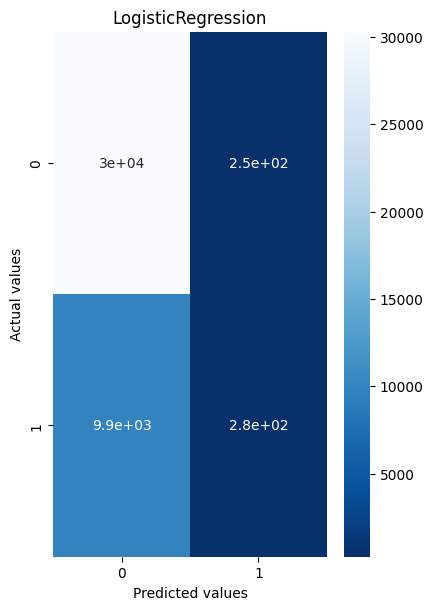

In [92]:
fig = plt.figure(figsize = (15,15))
sub = fig.add_subplot(2,3,1).set_title("LogisticRegression")
cm_plot = sns.heatmap(cm_list, annot=True, cmap = "Blues_r")
cm_plot.set_xlabel("Predicted values")
cm_plot.set_ylabel("Actual values")

In [94]:
report = classification_report(y_test, Y_pred, target_names=["Actual", "Pred"])
report

'              precision    recall  f1-score   support\n\n      Actual       0.75      0.99      0.86     30544\n        Pred       0.53      0.03      0.05     10139\n\n    accuracy                           0.75     40683\n   macro avg       0.64      0.51      0.45     40683\nweighted avg       0.70      0.75      0.66     40683\n'

In [1]:
NB = GaussianNB()
NB.fit(X_train.todense(), y_train)
Y_pred_NB = NB.predict(X_test)
accuracy_NB = metrics.accuracy_score(y_test, Y_pred)
fpr, tpr, _thersholds = metrics.roc_curve(y_test, Y_pred_NB)
auc_list_NB = round(metrics.auc(fpr, tpr),2)
cm_list_NB =  confusion_matrix(y_test, Y_pred_NB)

NameError: name 'GaussianNB' is not defined

In [ ]:
fig1 = plt.figure(figsize = (15,15))
sub = fig1.add_subplot(2,3,1).set_title("GaussianNB")
cm_plot1 = sns.heatmap(cm_list_NB, annot=True, cmap = "Blues_r")
cm_plot1.set_xlabel("Predicted values")
cm_plot1.set_ylabel("Actual values")

In [ ]:
report = classification_report(y_test, Y_pred_NB, target_names=["Actual", "Pred"])
report